In [4]:
import pandas as pd

In [5]:

df = pd.read_csv("C:/Users/ELCOT/Downloads/evcharging/SYNTHETIC_EV_DATA.csv")
df.head()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965239 entries, 0 to 1965238
Data columns (total 4 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   connectionTime_decimal  float64
 1   chargingDuration        float64
 2   kWhDelivered            float64
 3   dayIndicator            int64  
dtypes: float64(3), int64(1)
memory usage: 60.0 MB


,connectionTime_decimal,chargingDuration,kWhDelivered,dayIndicator
count,1.965239e+06,1.965239e+06,1.965239e+06,1.965239e+06
mean,1.448631e+01,3.800781e+00,9.437424e+00,1.480029e+04
std,6.427672e+00,3.387723e+00,5.700660e+00,8.531910e+03
min,7.236954e-06,1.384907e-05,3.700269e-04,1.000000e+00
25%,1.424779e+01,1.443232e+00,4.868768e+00,7.424000e+03
50%,1.616805e+01,2.547029e+00,9.174554e+00,1.479300e+04
75%,1.804136e+01,5.436214e+00,1.356673e+01,2.219800e+04
max,2.400000e+01,3.941106e+01,6.253769e+01,2.960000e+04


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os

In [7]:
df = pd.read_csv("C:/Users/ELCOT/Downloads/evcharging/SYNTHETIC_EV_DATA.csv")
df.head(10)

,connectionTime_decimal,chargingDuration,kWhDelivered,dayIndicator
0,15.332910,2.301191,11.469551,1
1,16.811495,4.941774,3.611695,1
2,21.151696,3.567173,14.455706,1
3,14.988554,3.089371,5.985330,1
4,15.078276,0.145047,1.274458,1
5,1.374939,1.019991,7.327850,1
6,16.680561,0.875763,6.760685,1
7,18.731514,1.246924,4.272613,1
8,17.356366,5.696375,11.462980,1
9,14.659115,5.727056,5.936734,1


In [8]:
base_date = pd.Timestamp("2024-01-01")  
df["timestamp"] = (
    base_date
    + pd.to_timedelta(df["dayIndicator"] - 1, unit="D")
    + pd.to_timedelta(df["connectionTime_decimal"], unit="h")
)

df[["dayIndicator","connectionTime_decimal","timestamp"]].head(10)


,dayIndicator,connectionTime_decimal,timestamp
0,1,15.332910,2024-01-01 15:19:58.474941600
1,1,16.811495,2024-01-01 16:48:41.382810000
2,1,21.151696,2024-01-01 21:09:06.104595600
3,1,14.988554,2024-01-01 14:59:18.792909600
4,1,15.078276,2024-01-01 15:04:41.795306400
5,1,1.374939,2024-01-01 01:22:29.781325200
6,1,16.680561,2024-01-01 16:40:50.017915200
7,1,18.731514,2024-01-01 18:43:53.449989600
8,1,17.356366,2024-01-01 17:21:22.917376800
9,1,14.659115,2024-01-01 14:39:32.813668800


In [9]:
df = df.sort_values("timestamp")
df = df.dropna(subset=["timestamp", "kWhDelivered"])   # keep only useful rows
df = df.set_index("timestamp")
print("Rows after cleaning:", len(df))

Rows after cleaning: 1965239


In [10]:
ts = df["kWhDelivered"].resample("D").sum().fillna(0)
print("Daily time series length:", len(ts))
ts.head()

Daily time series length: 29600


timestamp
2024-01-01    414.863606
2024-01-02    566.181525
2024-01-03    634.367046
2024-01-04    612.431604
2024-01-05    517.117013
Freq: D, Name: kWhDelivered, dtype: float64

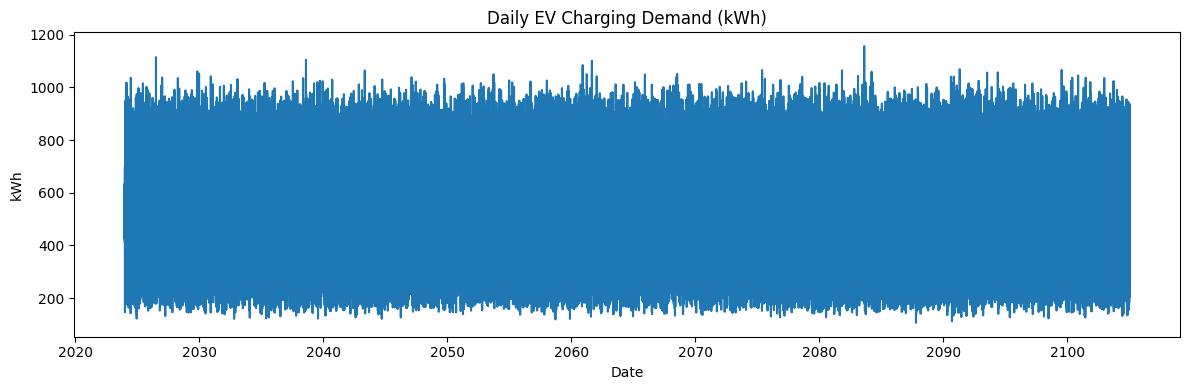

In [11]:
plt.figure(figsize=(12,4))
plt.plot(ts.index, ts.values)
plt.title("Daily EV Charging Demand (kWh)")
plt.xlabel("Date"); plt.ylabel("kWh")
plt.tight_layout()
plt.show()

In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [13]:
forecast_horizon = 7  # days ahead
model = ExponentialSmoothing(ts, trend='add', seasonal=None)   # fast & stable
fit = model.fit(optimized=True)
pred = fit.forecast(forecast_horizon)

# Forecast dataframe
forecast_df = pd.DataFrame({
    "Date": pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1),
                          periods=forecast_horizon, freq="D"),
    "Predicted_kWh": pred.values
})
forecast_df


C:\Users\ELCOT\miniconda3\envs\myenv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


,Date,Predicted_kWh
0,2105-01-16,567.865857
1,2105-01-17,567.374592
2,2105-01-18,566.883327
3,2105-01-19,566.392063
4,2105-01-20,565.900798
5,2105-01-21,565.409533
6,2105-01-22,564.918268


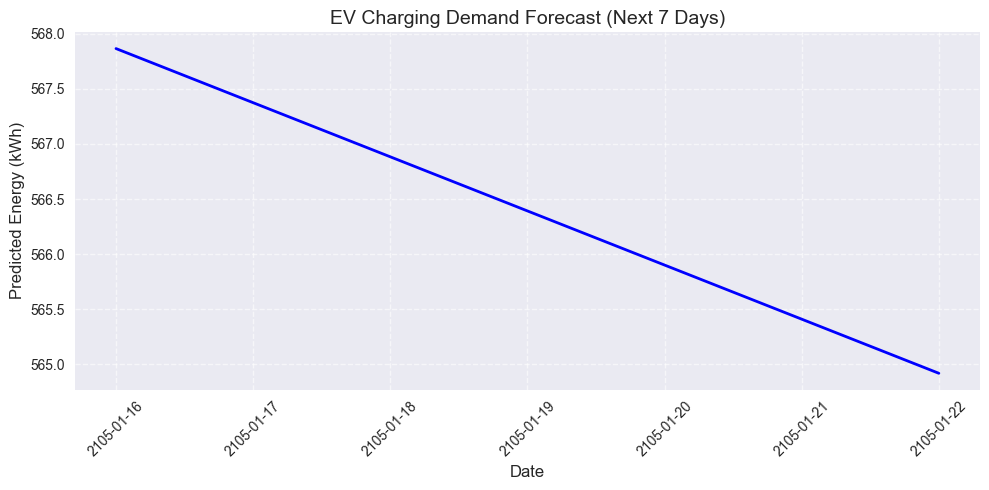

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(forecast_df["Date"], forecast_df["Predicted_kWh"], color='blue', linewidth=2)

plt.title("EV Charging Demand Forecast (Next 7 Days)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Predicted Energy (kWh)", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [21]:
import os

file_path = r"C:\Users\ELCOT\Downloads\evcharging\SYNTHETIC_EV_DATA.CSV"

output_dir = os.path.dirname(file_path)

print("Output directory set to:", output_dir)


Output directory set to: C:\Users\ELCOT\Downloads\evcharging
